<div style="text-align: center"><img width=300px src="https://cdn.modernghana.com/images/content/aflatoxin_infested_maize.jpg"></div>

# Transfer of Aflatoxin from Maize to Milk a reproducible use case

>This notebook is here to demonstrate integration of various models build within RIKILT to form a chain. 
This prototype deals here with aflatoxin contamination in maize and how it is transfered to milk following consumption by cows in dutch farms, as new models become available (example: Wheat, Barley and other grains); new set of features will be added.

>For simple set up we have chained together here crop phenology model, forecasting model and carry over model. All models mentioned here are exposed as a ***RESTful API*** 


## Learned parameters obtained from Alterra more information at
#### https://git.wageningenur.nl/Gavai001/KB_Big_Data_Project/tree/master/cropPhenologyModels/data


## Read the model parameters for the whole Europe
> This is a part of crop Phenology model


In [1]:
setwd("~/KB_Big_Data_Project/cropPhenologyModels/")
require(gdata)
flo_har = read.csv(".//data//Maize.csv",header=TRUE)

Loading required package: gdata
gdata: read.xls support for 'XLS' (Excel 97-2004) files ENABLED.

gdata: read.xls support for 'XLSX' (Excel 2007+) files ENABLED.

Attaching package: ‘gdata’

The following object is masked from ‘package:stats’:

    nobs

The following object is masked from ‘package:utils’:

    object.size

The following object is masked from ‘package:base’:

    startsWith



## Flowering data and Harvest data form the basis of forecasting models:
* These data was calculated as follows:
 sum of average daily temperature from start_date.
 For winter wheat, Tbase = 0, Tmax = 30
 For grain maize, Tbase = 10, Tmax= 30
 For spring barley, Tbase = 0, Tmax=35
 which means tsum starts to cummulate when average T
 is between Tbase and Tmax.

* Harvest data was calculated in a similar fashion

In [2]:
colnames(flo_har)<-c("GRID_NO","crop_no","variety_no","start_type","start_date","start_day","start_month","flowering_data","harvest_data")


## These model parameters form basis for forecasting models

In [3]:
setwd("~/KB_Big_Data_Project/forecastingModels/maize_Aflatoxin_R/src/")

## Select the data to choose from
* "DE_data.csv" = Germany
* "Fr_Data.csv" = France
* "IT_data.csv" = Italy
* "NL_data.csv" = Italy
* "Rom_data.csv"= Romania
* "SRB_data.csv"= Serbia                           
* "UK_data.csv" = United Kingdom
* "UKR_data.csv" = Ukraine                           


In [4]:
country = "NL_data.csv"

## Read in the parameters learned from Crop Phenology model
> This is a part of forcasting model

> Pass flowering and Harvest data from Crop Phenology model to Forecasting model

In [5]:

file<-paste0("~/KB_Big_Data_Project/forecastingModels/maize_Aflatoxin_R/data/input/",country)
dat<-read.csv(file,sep=";")

require("sqldf")
dat<-sqldf("select * from dat left join flo_har on dat.GRID_NO=flo_har.GRID_NO")
dat<-dat[,c("GRID_NO","LATITUDE","LONGITUDE","ALTITUDE","DAY","TEMPERATURE_MAX","TEMPERATURE_MIN","VAPOURPRESSURE","PRECIPITATION","flowering_data","harvest_data")]

Loading required package: sqldf
Loading required package: gsubfn
Loading required package: proto
Loading required package: RSQLite


## Load the Aflatoxin Maize Model

In [6]:
source("~/KB_Big_Data_Project/forecastingModels/maize_Aflatoxin_R/src/Aflatoxin_model.R")


## Get the predictions for Aflatoxins levels in Maize


In [7]:
aflatoxinPredictionsInMaize<-getAflatoxinMaizePredictions(dat)


## Sanity check if we see what we expect

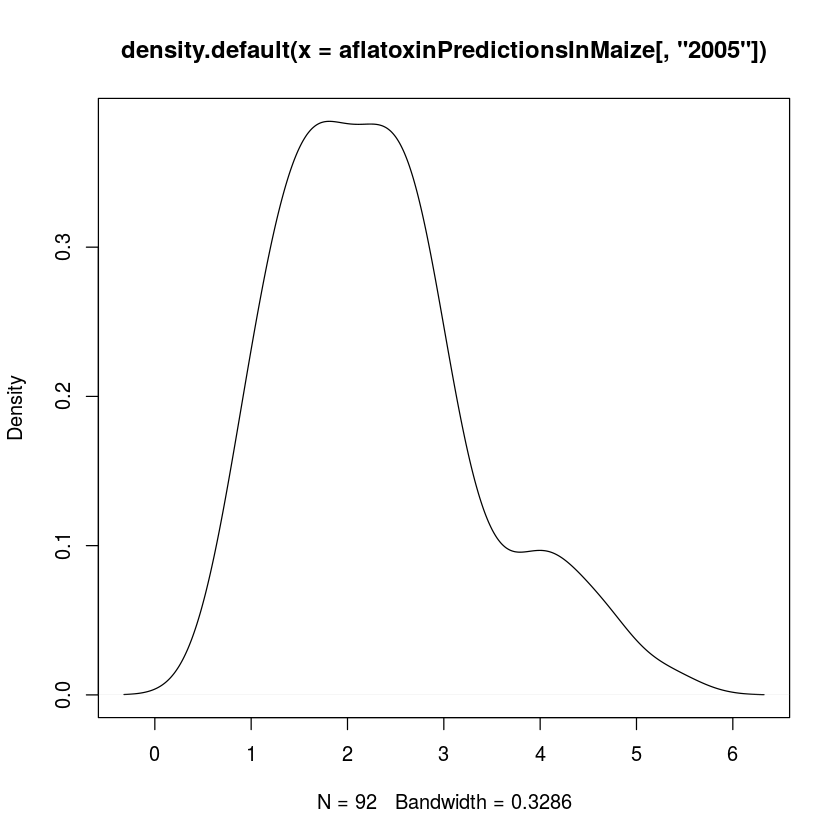

In [8]:
plot(density(aflatoxinPredictionsInMaize[,"2005"]))

## This is how the data looks like 

In [11]:
head(aflatoxinPredictionsInMaize)

grid_no,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
110102,2.886350,7.425126,1.881971,4.030927,2.497520,3.377260,1.1910934,3.991832,5.099385,4.630743,1.924437
111102,2.185168,6.055251,1.517426,3.174954,2.433063,1.745391,1.0887851,2.788023,3.651643,4.722299,1.577899
110100,1.835091,5.241631,1.011187,2.078384,1.524011,1.330355,0.6725768,2.395149,3.205619,4.166922,1.303422
108101,2.390204,5.886038,1.861994,3.542943,2.084233,2.418885,1.0688942,4.300079,4.970810,4.327245,2.254729
106100,2.795672,12.722661,2.442509,3.750411,2.991302,3.379441,1.2886008,4.769916,5.642206,4.627914,2.912504
105099,4.137476,16.873213,3.232305,4.303256,4.751562,6.050936,2.4700599,7.141930,6.140252,4.625291,3.990000


## Collect *Mean* and *Standard Deviation* for specific year 
> for example : "2005"

In [12]:
maizePredictions<-aflatoxinPredictionsInMaize[,"2015"]

meanMaizePredictions<-mean(maizePredictions)
sdMaizePredictions<-sd(maizePredictions)

maizePred<-c(meanMaizePredictions,sdMaizePredictions)

In [13]:
maizePred

[1] 2.360694 1.471513

## Select the compound feed composition scenario for example = 1,2,3, where:
* 1 = 2013 high protein diet
* 2 = 2013 low protein diet
* 3 = distribution data from min and max inclusion rates

In [14]:
CF_scenario = 1

## Select Milk yield scenario in farm for example: 1,2,3 or 4 where:
* 1 = one new cow starts to lactate per week: see presentation for figure
* 2 = all cows together
* 3 = high yield
* 4 = low yield

In [15]:
factor = 1


## Select ingredients Contamination scenario: 1 or 2 where:
* 1 = KAP data distribution
* 2 = high maize contamination

In [16]:
contamination_scenario <- 2

## Load the carry over milk model

In [17]:
source("~/KB_Big_Data_Project/carryOverModels/milkAflatoxinM1_Open/src/farm_Aflatoxin_model.R")

## Calculate predictions of Aflatoxin levels in Milk based on Monte Carlo Simulations
* Reference:
Effects of Milk Yield, Feed Composition, and Feed Contamination with Aflatoxin B1 on the Aflatoxin M1 Concentration in Dairy Cows' Milk Investigated Using Monte Carlo Simulation Modelling.
van der Fels-Klerx HJ1, Camenzuli L2. [https://www.ncbi.nlm.nih.gov/pubmed/27735836]

### Models are based on five equations derived from literature:
* Masoero, F.; Gallo, A.; Moschini, M.; Piva, G.; Diaz, D. Carry-over of aflatoxin from feed to milk in dairy
cows with low or high somatic cell counts. Animal 2007, 1, 1344–1350. 

* Veldman, A.; Meijs, J.A.C.; Borggreve, G.J.; Heeres-van der Tol, J.J. Carry-over of aflatoxin from cows’ food
to milk. Anim. Sci. 1992, 55, 163–168. 

* Britzi, M.; Friedman, S.; Miron, J.; Solomon, R.; Cuneah, O.; Shimshoni, J.; Soback, S.; Ashkenazi, R.;
Armer, S.; Shlosberg, A. Carry-over of aflatoxin B1 to aflatoxin M1 in high yielding Israeli cows in mid- and
late-lactation. Toxins 2013, 5, 173–183

* Van Eijkeren, J.C.H.; Bakker, M.I.; Zeilmaker, M.J. A simple steady-state model for carry-over of aflatoxins
from feed to cow’s milk. Food Addit. Contam. 2006, 23, 833–838

* European Food Safety Authority. Opinion of the scientific panel on contaminants in the food chain on a
request from the Commission related to aflatoxin B1 as undesirable substance in animal feed. EFSA J. 2004,
39, 1–27

## Predictions here are based on *Van Eijkeren et al*.

In [18]:
milkAflatoxinPredictions<-farm_Aflatoxin_model(CF_scenario,factor,contamination_scenario)


## There are in total 1000 simulations run over 52 weeks on 69 cows

For structure of the data looks like below

In [19]:
dim(milkAflatoxinPredictions)

[1] 1000   52   69

## Example:  first week for all cows for 1 simulation

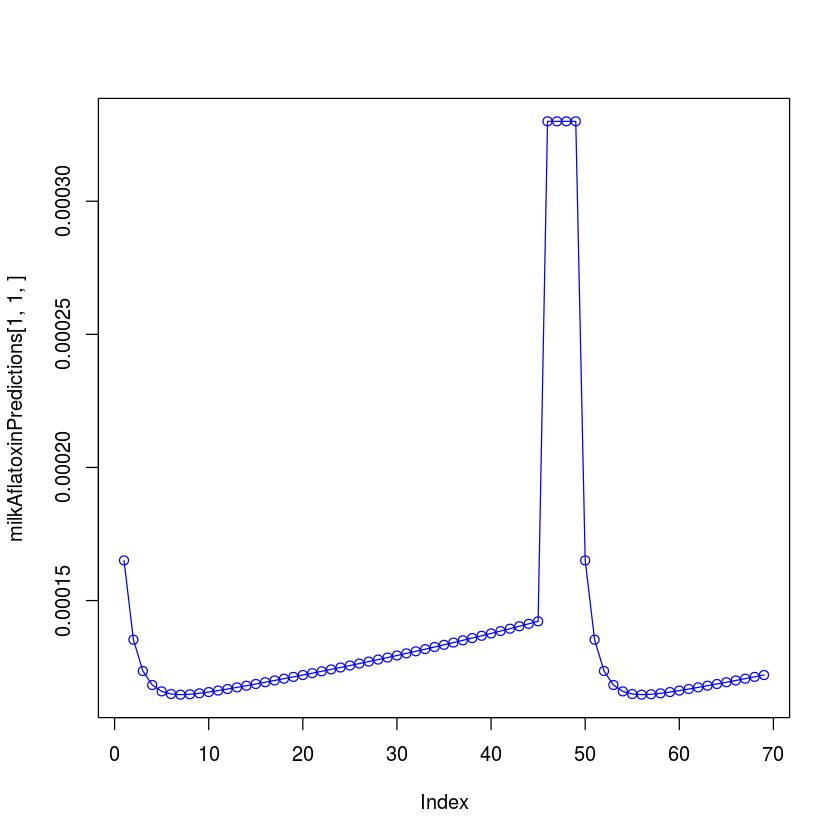

In [20]:
plot(milkAflatoxinPredictions[1,1,],type="o",col="blue")

## second week for all cows for 1 simulation


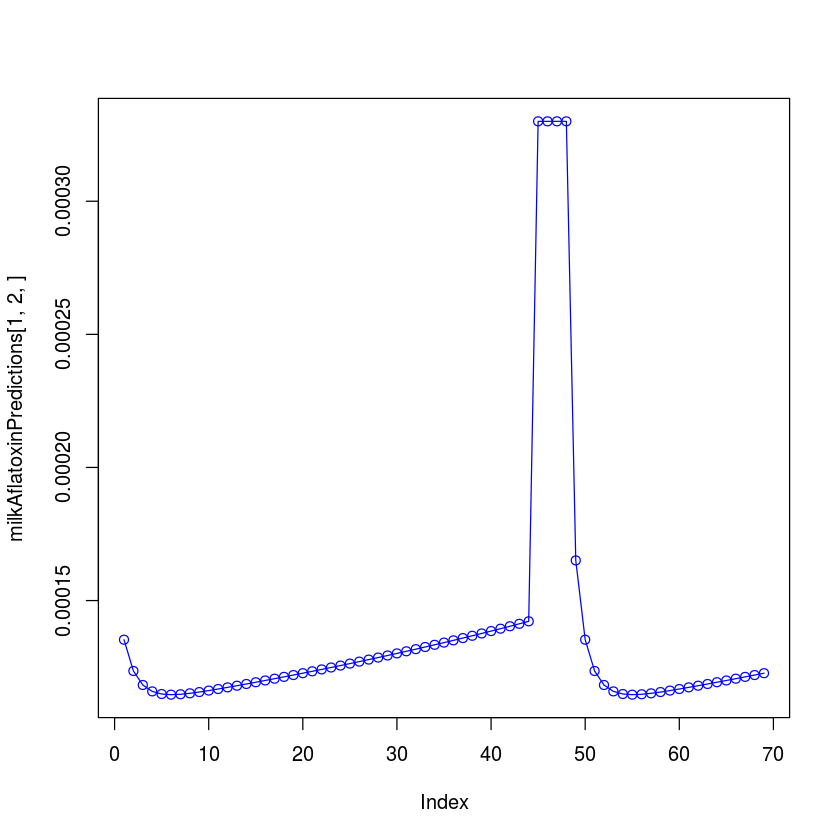

In [21]:
plot(milkAflatoxinPredictions[1,2,],type="o",col="blue")
